# Food Desert Project - Data Cleaning & Preprocessing

This notebook performs data cleaning and preprocessing for the Food Desert Effect project, which investigates how food access inequality affects community-level metabolic health outcomes.

**Data Sources:**
- County Health Rankings 2025 (Select Measure Data)
- County Health Rankings 2025 (Additional Measure Data)

**Objective:** Create a clean, analysis-ready dataset with engineered features for predictive modeling.

## 1. Import Libraries

In [4]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tools
from scipy import stats
from scipy.stats import f_oneway

# Machine Learning preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Plot settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("All libraries imported successfully")

All libraries imported successfully


## 2. Load Raw Data

We'll load two sheets from the County Health Rankings Excel file and merge them.

In [8]:
# File path
excel_file = '/Users/savithavijayarangan/Desktop/ML group project/data/raw/2025CountyHealthRankingsDatav3.xlsx'


# Load both sheets
print("Loading data sheets...")
df_select = pd.read_excel(excel_file, sheet_name='Select Measure Data', skiprows=1)
df_additional = pd.read_excel(excel_file, sheet_name='Additional Measure Data', skiprows=1)

print(f"Select Measure Data shape: {df_select.shape}")
print(f"Additional Measure Data shape: {df_additional.shape}")

# Merge on FIPS, State, County
df = pd.merge(df_select, df_additional, on=['FIPS', 'State', 'County'], how='inner', suffixes=('', '_add'))

print(f"\nMerged dataset shape: {df.shape}")
print(f"Total columns: {df.shape[1]}")
print(f"Total counties: {df.shape[0]:,}")

Loading data sheets...
Select Measure Data shape: (3210, 225)
Additional Measure Data shape: (3210, 395)

Merged dataset shape: (3210, 617)
Total columns: 617
Total counties: 3,210


### 2.1 Explore Available Columns

In [9]:
# Display first few rows
print("First 3 rows of merged dataset:")
df.head(3)

First 3 rows of merged dataset:


,FIPS,State,County,Unreliable,Deaths,Years of Potential Life Lost Rate,95% CI - Low,95% CI - High,National Z-Score,YPLL Rate (Hispanic (all races)),YPLL Rate (Hispanic (all races)) 95% CI - Low,YPLL Rate (Hispanic (all races)) 95% CI - High,YPLL Rate (Hispanic (all races)) Unreliable,YPLL Rate (Non-Hispanic AIAN),YPLL Rate (Non-Hispanic AIAN) 95% CI - Low,YPLL Rate (Non-Hispanic AIAN) 95% CI - High,YPLL Rate (Non-Hispanic AIAN) Unreliable,YPLL Rate (Non-Hispanic Asian),YPLL Rate (Non-Hispanic Asian) 95% CI - Low,YPLL Rate (Non-Hispanic Asian) 95% CI - High,YPLL Rate (Non-Hispanic Asian) Unreliable,YPLL Rate (Non-Hispanic Black),YPLL Rate (Non-Hispanic Black) 95% CI - Low,YPLL Rate (Non-Hispanic Black) 95% CI - High,YPLL Rate (Non-Hispanic Black) Unreliable,YPLL Rate (Non-Hispanic Native Hawaiian and Other Pacific Islander),YPLL Rate (Non-Hispanic Native Hawaiian and Other Pacific Islander) 95% CI - Low,YPLL Rate (Non-Hispanic Native Hawaiian and Other Pacific Islander) 95% CI - High,YPLL Rate (Non-Hispanic Native Hawaiian and Other Pacific Islander) Unreliable,YPLL Rate (Non-Hispanic 2+ races),YPLL Rate (Non-Hispanic 2+ races) 95% CI - Low,YPLL Rate (Non-Hispanic 2+ races) 95% CI - High,YPLL Rate (Non-Hispanic 2+ races) Unreliable,YPLL Rate (Non-Hispanic White),YPLL Rate (Non-Hispanic White) 95% CI - Low,YPLL Rate (Non-Hispanic White) 95% CI - High,YPLL Rate (Non-Hispanic White) Unreliable,Average Number of Physically Unhealthy Days,95% CI - Low.1,95% CI - High.1,National Z-Score.1,Unreliable.1,% Low Birth Weight,95% CI - Low.2,95% CI - High.2,National Z-Score.2,% LBW (Hispanic (all races)),% LBW (Hispanic (all races)) 95% CI - Low,% LBW (Hispanic (all races)) 95% CI - High,% LBW (Non-Hispanic AIAN),% LBW (Non-Hispanic AIAN) 95% CI - Low,% LBW (Non-Hispanic AIAN) 95% CI - High,% LBW (Non-Hispanic Asian),% LBW (Non-Hispanic Asian) 95% CI - Low,% LBW (Non-Hispanic Asian) 95% CI - High,% LBW (Non-Hispanic Black),% LBW (Non-Hispanic Black) 95% CI - Low,% LBW (Non-Hispanic Black) 95% CI - High,% LBW (Non-Hispanic Native Hawaiian and Other Pacific Islander),% LBW (Non-Hispanic Native Hawaiian and Other Pacific Islander) 95% CI - Low,% LBW (Non-Hispanic Native Hawaiian and Other Pacific Islander) 95% CI - High,% LBW (Non-Hispanic 2+ races),% LBW (Non-Hispanic 2+ races) 95% CI - Low,% LBW (Non-Hispanic 2+ races) 95% CI - High,% LBW (Non-Hispanic White),% LBW (Non-Hispanic White) 95% CI - Low,% LBW (Non-Hispanic White) 95% CI - High,Average Number of Mentally Unhealthy Days,95% CI - Low.3,95% CI - High.3,National Z-Score.3,% Fair or Poor Health,95% CI - Low.4,95% CI - High.4,National Z-Score.4,% Vaccinated,National Z-Score.5,% Vaccinated (AIAN),% Vaccinated (Asian),% Vaccinated (Black),% Vaccinated (Hispanic),% Vaccinated (White),% With Access to Exercise Opportunities,National Z-Score.6,Food Environment Index,National Z-Score.7,# Primary Care Physicians,Primary Care Physicians Rate,Primary Care Physicians Ratio,National Z-Score.8,# Mental Health Providers,Mental Health Provider Rate,Mental Health Provider Ratio,National Z-Score.9,# Dentists,Dentist Rate,Dentist Ratio,National Z-Score.10,Preventable Hospitalization Rate,National Z-Score.11,Preventable Hosp. Rate (AIAN),Preventable Hosp. Rate (Asian),Preventable Hosp. Rate (Black),Preventable Hosp. Rate (Hispanic),Preventable Hosp. Rate (White),% with Annual Mammogram,National Z-Score.12,% Screened (AIAN),% Screened (Asian),% Screened (Black),% Screened (Hispanic),% Screened (White),# Uninsured,% Uninsured,95% CI - Low.5,95% CI - High.5,National Z-Score.13,% Severe Housing Problems,95% CI - Low.6,95% CI - High.6,Severe Housing Cost Burden,Severe Housing Cost Burden 95% CI - Low,Severe Housing Cost Burden 95% CI - High,Overcrowding,Overcrowding 95% CI - Low,Overcrowding 95% CI - High,Inadequate Facilities,Inadequate Facilities 95% CI - Low,Inadequate Facilities 95% CI - High,National Z-Score.14,% Drive Alone to Work,95% CI - Low.7,95% CI - High.7,National Z-Score.15,% Drive Alone (AIAN),

In [10]:
# Search for key columns
keywords = ['obesity', 'diabetes', 'food', 'income', 'poverty', 'education', 'rural']

print("Key columns by topic:\n")
for keyword in keywords:
    matching = [col for col in df.columns if keyword.lower() in col.lower()]
    if matching:
        print(f"\n{keyword.upper()}:")
        for col in matching[:5]:  # Show first 5
            print(f"  • {col}")
        if len(matching) > 5:
            print(f"  ... and {len(matching) - 5} more")

Key columns by topic:


OBESITY:
  • % Adults with Obesity

DIABETES:
  • % Adults with Diabetes

FOOD:
  • Food Environment Index
  • # Limited Access to Healthy Foods
  • % Limited Access to Healthy Foods
  • # Food Insecure
  • % Food Insecure

INCOME:
  • 80th Percentile Income
  • 20th Percentile Income
  • Income Ratio
  • % Household Income Required for Child Care Expenses
  • Median Household Income
  ... and 15 more

POVERTY:
  • % Children in Poverty
  • % Children in Poverty (AIAN)
  • % Children in Poverty (Asian)
  • % Children in Poverty (Black)
  • % Children in Poverty (Hispanic)
  ... and 1 more

RURAL:
  • # Rural Residents
  • % Rural


## 3. Select Relevant Columns

Based on our project requirements, we'll select columns related to:
- Health outcomes (obesity, diabetes)
- Food environment
- Socioeconomic factors
- Education
- Demographics

In [11]:
# Define columns we want to keep
selected_columns = [
    # Identifiers
    'FIPS', 'State', 'County',
    
    # Health Outcomes (PRIMARY TARGETS)
    '% Adults with Obesity',
    '% Adults with Diabetes',
    'Average Number of Physically Unhealthy Days',
    
    # Food Environment
    'Food Environment Index',
    
    # Socioeconomic Factors
    '80th Percentile Income',
    '20th Percentile Income',
    'Income Ratio',
    '% Children in Poverty',
    '% Uninsured',
    
    # Education
    '% Some College',
    '% Completed High School',
    
    # Healthcare Access
    'Primary Care Physicians Ratio',
    '# Primary Care Physicians',
    
    # Demographics
    'Population',
    '% Not Proficient in English',
    '% Rural',
    
    # Additional Health Behaviors
    '% Excessive Drinking',
    '% Insufficient Sleep'
]

# Check which columns are available
available_cols = [col for col in selected_columns if col in df.columns]
missing_cols = [col for col in selected_columns if col not in df.columns]

print(f"Requested columns: {len(selected_columns)}")
print(f"Available columns: {len(available_cols)}")
print(f"Missing columns: {len(missing_cols)}")

if missing_cols:
    print("\nMissing columns:")
    for col in missing_cols:
        print(f"  • {col}")

# Select available columns
df = df[available_cols].copy()

print(f"\nDataset reduced to {df.shape[1]} columns")

Requested columns: 21
Available columns: 21
Missing columns: 0

Dataset reduced to 21 columns


In [12]:
# Display selected columns
print("Selected columns:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

Selected columns:
 1. FIPS
 2. State
 3. County
 4. % Adults with Obesity
 5. % Adults with Diabetes
 6. Average Number of Physically Unhealthy Days
 7. Food Environment Index
 8. 80th Percentile Income
 9. 20th Percentile Income
10. Income Ratio
11. % Children in Poverty
12. % Uninsured
13. % Some College
14. % Completed High School
15. Primary Care Physicians Ratio
16. # Primary Care Physicians
17. Population
18. % Not Proficient in English
19. % Rural
20. % Excessive Drinking
21. % Insufficient Sleep


## 4. Handle Missing Data

### 4.1 Assess Missing Data

In [13]:
# Calculate missing data statistics
missing_stats = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Percent': (df.isnull().sum() / len(df) * 100).values
}).sort_values('Missing_Percent', ascending=False)

print("Missing Data Summary:")
print("=" * 70)
print(f"Total cells: {df.shape[0] * df.shape[1]:,}")
print(f"Missing cells: {df.isnull().sum().sum():,}")
print(f"Missing percentage: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100):.2f}%")
print("\nColumns with missing data:")
print(missing_stats[missing_stats['Missing_Count'] > 0])

Missing Data Summary:
Total cells: 67,410
Missing cells: 751
Missing percentage: 1.11%

Columns with missing data:
                                         Column  Missing_Count  \
14                Primary Care Physicians Ratio            173   
15                    # Primary Care Physicians            173   
6                        Food Environment Index             59   
2                                        County             51   
7                        80th Percentile Income             37   
8                        20th Percentile Income             37   
9                                  Income Ratio             37   
10                        % Children in Poverty             16   
16                                   Population             16   
11                                  % Uninsured             16   
12                               % Some College             16   
19                         % Excessive Drinking             15   
18                         

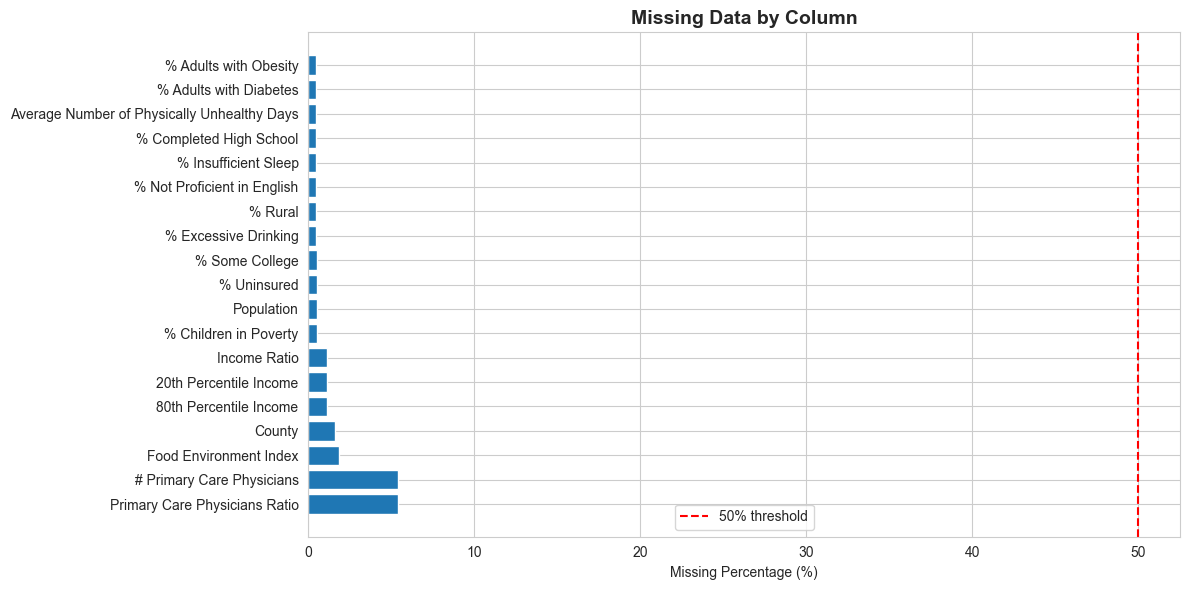

Missing data visualization complete


In [14]:
# Visualize missing data
plt.figure(figsize=(12, 6))
missing_cols = missing_stats[missing_stats['Missing_Count'] > 0]
plt.barh(range(len(missing_cols)), missing_cols['Missing_Percent'])
plt.yticks(range(len(missing_cols)), missing_cols['Column'])
plt.xlabel('Missing Percentage (%)')
plt.title('Missing Data by Column', fontweight='bold', fontsize=14)
plt.axvline(x=50, color='r', linestyle='--', label='50% threshold')
plt.legend()
plt.tight_layout()
plt.show()

print("Missing data visualization complete")

### 4.2 Remove Columns with High Missing Data

In [15]:
# Remove columns with >50% missing data
threshold = 50
high_missing_cols = missing_stats[missing_stats['Missing_Percent'] > threshold]['Column'].tolist()

# Keep essential columns even if they have high missing data
essential_cols = ['FIPS', 'State', 'County']
high_missing_cols = [col for col in high_missing_cols if col not in essential_cols]

if high_missing_cols:
    print(f"Removing {len(high_missing_cols)} columns with >{threshold}% missing data:")
    for col in high_missing_cols:
        print(f"  • {col}")
    df = df.drop(columns=high_missing_cols)
else:
    print(f"No columns have >{threshold}% missing data")

print(f"\nDataset shape after removal: {df.shape}")

No columns have >50% missing data

Dataset shape after removal: (3210, 21)


### 4.3 Remove Rows with Missing FIPS

In [16]:
# Remove rows where FIPS is missing (can't identify county)
before_count = len(df)
df = df.dropna(subset=['FIPS'])
after_count = len(df)

print(f"Rows removed due to missing FIPS: {before_count - after_count}")
print(f"Remaining rows: {after_count:,}")

Rows removed due to missing FIPS: 0
Remaining rows: 3,210


## 5. Data Type Conversion

In [17]:
# Convert FIPS to string with leading zeros
df['FIPS'] = df['FIPS'].astype(str).str.zfill(5)

# Convert numeric columns
exclude_cols = ['FIPS', 'State', 'County']
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

print(f"Converting {len(numeric_cols)} columns to numeric type...")
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\nData types converted")
print("\nData types summary:")
print(df.dtypes.value_counts())

Converting 17 columns to numeric type...

Data types converted

Data types summary:
float64    17
object      4
Name: count, dtype: int64


## 6. Feature Engineering

Create composite indices for better analysis

In [18]:
print("Creating engineered features...\n")

# 1. Food Access Barrier Index
if all(col in df.columns for col in ['Food Environment Index', '80th Percentile Income', '% Children in Poverty']):
    df['Food_Access_Barrier_Index'] = (
        (10 - df['Food Environment Index']) / 10 * 0.4 +  # Inverted (higher = worse)
        (1 - df['80th Percentile Income'] / df['80th Percentile Income'].max()) * 0.3 +
        (df['% Children in Poverty'] / 100) * 0.3
    )
    print("Created Food_Access_Barrier_Index")
    print(f"  Range: [{df['Food_Access_Barrier_Index'].min():.3f}, {df['Food_Access_Barrier_Index'].max():.3f}]")
    print(f"  Mean: {df['Food_Access_Barrier_Index'].mean():.3f}")

# 2. Socioeconomic Vulnerability Index
if all(col in df.columns for col in ['% Children in Poverty', '% Uninsured']):
    components = []
    weights = []
    
    components.append(df['% Children in Poverty'] / 100)
    weights.append(0.4)
    
    components.append(df['% Uninsured'] / 100)
    weights.append(0.3)
    
    if '% Completed High School' in df.columns:
        components.append(1 - df['% Completed High School'] / 100)
        weights.append(0.3)
    
    # Normalize weights
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]
    
    df['Socioeconomic_Vulnerability_Index'] = sum(c * w for c, w in zip(components, weights))
    print("\nCreated Socioeconomic_Vulnerability_Index")
    print(f"  Range: [{df['Socioeconomic_Vulnerability_Index'].min():.3f}, {df['Socioeconomic_Vulnerability_Index'].max():.3f}]")
    print(f"  Mean: {df['Socioeconomic_Vulnerability_Index'].mean():.3f}")

# 3. Health Risk Score
if all(col in df.columns for col in ['% Adults with Obesity', '% Adults with Diabetes']):
    df['Health_Risk_Score'] = (
        (df['% Adults with Obesity'] / 100) * 0.6 +
        (df['% Adults with Diabetes'] / 100) * 0.4
    )
    print("\nCreated Health_Risk_Score")
    print(f"  Range: [{df['Health_Risk_Score'].min():.3f}, {df['Health_Risk_Score'].max():.3f}]")
    print(f"  Mean: {df['Health_Risk_Score'].mean():.3f}")

# 4. Area Type Classification
if '% Rural' in df.columns:
    df['Area_Type'] = pd.cut(
        df['% Rural'],
        bins=[-0.1, 20, 50, 100],
        labels=['Urban', 'Suburban', 'Rural']
    )
    print("\nCreated Area_Type")
    print("  Distribution:")
    print(df['Area_Type'].value_counts())

# 5. High Income Inequality Indicator
if 'Income Ratio' in df.columns:
    median_ratio = df['Income Ratio'].median()
    df['High_Income_Inequality'] = (df['Income Ratio'] > median_ratio).astype(int)
    print(f"\nCreated High_Income_Inequality (threshold: {median_ratio:.2f})")
    print(f"  High inequality counties: {df['High_Income_Inequality'].sum():,} ({df['High_Income_Inequality'].mean()*100:.1f}%)")

print("\n" + "="*70)
print(f"Total engineered features: 5")
print(f"Dataset shape: {df.shape}")

Creating engineered features...

Created Food_Access_Barrier_Index
  Range: [0.027, 0.735]
  Mean: 0.309

Created Socioeconomic_Vulnerability_Index
  Range: [0.025, 0.420]
  Mean: 0.141

Created Health_Risk_Score
  Range: [0.137, 0.396]
  Mean: 0.272

Created Area_Type
  Distribution:
Area_Type
Rural       2014
Suburban     730
Urban        451
Name: count, dtype: int64

Created High_Income_Inequality (threshold: 4.42)
  High inequality counties: 1,586 (49.4%)

Total engineered features: 5
Dataset shape: (3210, 26)


## 7. Outlier Detection and Removal

In [19]:
# Select numeric columns for outlier detection
exclude_cols = ['FIPS', 'Population', 'High_Income_Inequality']
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
outlier_cols = [col for col in numeric_cols if col not in exclude_cols]

print(f"Detecting outliers using IQR method...")
print(f"Analyzing {len(outlier_cols)} columns\n")

before_count = len(df)

# IQR method
outlier_mask = pd.Series([False] * len(df))

for col in outlier_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    col_outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_mask = outlier_mask | col_outliers

# Remove outliers
df = df[~outlier_mask]
after_count = len(df)

print(f"Rows before outlier removal: {before_count:,}")
print(f"Rows after outlier removal: {after_count:,}")
print(f"Outliers removed: {before_count - after_count:,} ({(before_count - after_count)/before_count*100:.2f}%)")
print(f"\nOutlier removal complete")

Detecting outliers using IQR method...
Analyzing 19 columns

Rows before outlier removal: 3,210
Rows after outlier removal: 2,275
Outliers removed: 935 (29.13%)

Outlier removal complete


## 8. Feature Normalization

Create normalized versions (z-scores) of numeric features for modeling

In [20]:
# Select columns to normalize
exclude_from_norm = ['FIPS', 'State', 'County', 'Area_Type', 'Population', 'High_Income_Inequality']
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols_to_normalize = [col for col in numeric_cols if col not in exclude_from_norm]

print(f"Creating normalized versions of {len(cols_to_normalize)} features...\n")

# Z-score normalization
for col in cols_to_normalize:
    if df[col].std() > 0:  # Only normalize if there's variation
        df[col + '_normalized'] = stats.zscore(df[col], nan_policy='omit')

normalized_cols = [col for col in df.columns if '_normalized' in col]
print(f"Created {len(normalized_cols)} normalized features")
print(f"\nDataset shape: {df.shape}")

Creating normalized versions of 19 features...

Created 19 normalized features

Dataset shape: (2275, 45)


In [21]:
# Verify normalization
sample_col = cols_to_normalize[0]
print(f"Normalization verification for '{sample_col}':")
print(f"Original - Mean: {df[sample_col].mean():.3f}, Std: {df[sample_col].std():.3f}")
print(f"Normalized - Mean: {df[sample_col + '_normalized'].mean():.6f}, Std: {df[sample_col + '_normalized'].std():.3f}")

# Should be approximately 0 mean and 1 std
assert abs(df[sample_col + '_normalized'].mean()) < 0.001, "Normalized mean should be ~0"
assert abs(df[sample_col + '_normalized'].std() - 1.0) < 0.01, "Normalized std should be ~1"
print("\nNormalization verified")

Normalization verification for '% Adults with Obesity':
Original - Mean: 38.502, Std: 3.646
Normalized - Mean: 0.000000, Std: 1.000

Normalization verified


## 9. Data Summary

In [22]:
print("="*70)
print("CLEANED DATASET SUMMARY")
print("="*70)

print(f"\nDimensions: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nColumn Categories:")
print(f"  • Identifiers: 3 (FIPS, State, County)")
print(f"  • Original features: {len([c for c in df.columns if '_normalized' not in c and c not in ['FIPS', 'State', 'County']])}")
print(f"  • Normalized features: {len(normalized_cols)}")

print("\nData Quality:")
missing_pct = (df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100)
print(f"  • Missing data: {missing_pct:.2f}%")
print(f"  • Complete rows: {df.dropna().shape[0]:,} ({df.dropna().shape[0]/len(df)*100:.1f}%)")

print("\nGeographic Coverage:")
print(f"  • States: {df['State'].nunique()}")
print(f"  • Counties: {len(df):,}")

if 'Area_Type' in df.columns:
    print("\nArea Type Distribution:")
    for area, count in df['Area_Type'].value_counts().items():
        print(f"  • {area}: {count:,} ({count/len(df)*100:.1f}%)")

CLEANED DATASET SUMMARY

Dimensions: 2,275 rows × 45 columns
Memory usage: 1.19 MB

Column Categories:
  • Identifiers: 3 (FIPS, State, County)
  • Original features: 23
  • Normalized features: 19

Data Quality:
  • Missing data: 0.83%
  • Complete rows: 2,132 (93.7%)

Geographic Coverage:
  • States: 48
  • Counties: 2,275

Area Type Distribution:
  • Rural: 1,689 (74.2%)
  • Suburban: 493 (21.7%)
  • Urban: 83 (3.6%)


In [23]:
# Display descriptive statistics for key health variables
key_health_vars = [
    '% Adults with Obesity',
    '% Adults with Diabetes',
    'Food Environment Index',
    '% Children in Poverty',
    'Health_Risk_Score'
]

available_health_vars = [col for col in key_health_vars if col in df.columns]

print("\nKey Health Metrics - Descriptive Statistics:")
df[available_health_vars].describe()


Key Health Metrics - Descriptive Statistics:


,% Adults with Obesity,% Adults with Diabetes,Food Environment Index,% Children in Poverty,Health_Risk_Score
count,2265.000,2265.000,2237.000,2265.000,2265.000
mean,38.502,10.942,7.488,18.757,0.275
std,3.646,1.903,0.971,6.579,0.028
min,26.600,6.500,4.600,3.800,0.186
25%,36.300,9.500,6.900,13.600,0.258
50%,38.700,10.700,7.600,18.000,0.275
75%,41.000,12.300,8.200,22.900,0.293
max,49.100,16.900,9.900,38.400,0.359


## 10. Save Cleaned Dataset

In [27]:
# Save to CSV
#output_file = '/Users/savithavijayarangan/Desktop/ML group project/cleaned_health_data.csv'
df.to_csv(output_file, index=False)

#print(f"Cleaned dataset saved to: {output_file}")
#print(f"  Size: {pd.read_csv(output_file).memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Also save to outputs folder
output_file2 = '/Users/savithavijayarangan/Desktop/ML group project/data/output/cleaned_health_data.csv'
df.to_csv(output_file2, index=False)
print(f"Cleaned dataset saved to: {output_file2}")

Cleaned dataset saved to: /Users/savithavijayarangan/Desktop/ML group project/data/output/cleaned_health_data.csv


## 11. Data Validation

In [85]:
print("Running data validation checks...\n")

checks_passed = 0
total_checks = 0

# Check 1: No missing FIPS
total_checks += 1
if df['FIPS'].isnull().sum() == 0:
    print("Check 1: No missing FIPS codes")
    checks_passed += 1
else:
    print("Check 1: FAILED - Missing FIPS codes found")

# Check 2: FIPS codes are 5 digits
total_checks += 1
if df['FIPS'].str.len().eq(5).all():
    print("Check 2: All FIPS codes are 5 digits")
    checks_passed += 1
else:
    print("Check 2: FAILED - Invalid FIPS code lengths")

# Check 3: Health percentages are in valid range
total_checks += 1
health_pct_cols = ['% Adults with Obesity', '% Adults with Diabetes']
valid_ranges = True
for col in health_pct_cols:
    if col in df.columns:
        if not ((df[col] >= 0) & (df[col] <= 100)).all():
            valid_ranges = False
            break
if valid_ranges:
    print("Check 3: Health percentages in valid range (0-100)")
    checks_passed += 1
else:
    print("Check 3: FAILED - Invalid percentage values")

# Check 4: Engineered features created
total_checks += 1
engineered_features = [
    'Food_Access_Barrier_Index',
    'Socioeconomic_Vulnerability_Index',
    'Health_Risk_Score',
    'Area_Type',
    'High_Income_Inequality'
]
if all(feat in df.columns for feat in engineered_features):
    print("Check 4: All 5 engineered features created")
    checks_passed += 1
else:
    print("Check 4: FAILED - Missing engineered features")

# Check 5: Normalized features created
total_checks += 1
if len(normalized_cols) >= 15:
    print(f"Check 5: {len(normalized_cols)} normalized features created")
    checks_passed += 1
else:
    print(f"Check 5: FAILED - Only {len(normalized_cols)} normalized features")

# Check 6: Reasonable data retention
total_checks += 1
if len(df) >= 2000:
    print(f"Check 6: Good data retention ({len(df):,} counties)")
    checks_passed += 1
else:
    print(f"Check 6: FAILED - Low data retention ({len(df):,} counties)")

print(f"\n{'='*70}")
print(f"Validation Result: {checks_passed}/{total_checks} checks passed")
if checks_passed == total_checks:
    print(" ALL CHECKS PASSED - Dataset ready for modeling!")
else:
    print("Some checks failed - Review above messages")
print(f"{'='*70}")

Running data validation checks...

Check 1: No missing FIPS codes
Check 2: All FIPS codes are 5 digits
Check 3: FAILED - Invalid percentage values
Check 4: All 5 engineered features created
Check 5: 19 normalized features created
Check 6: Good data retention (2,275 counties)

Validation Result: 5/6 checks passed
Some checks failed - Review above messages


## 12. Quick Exploratory Visualizations

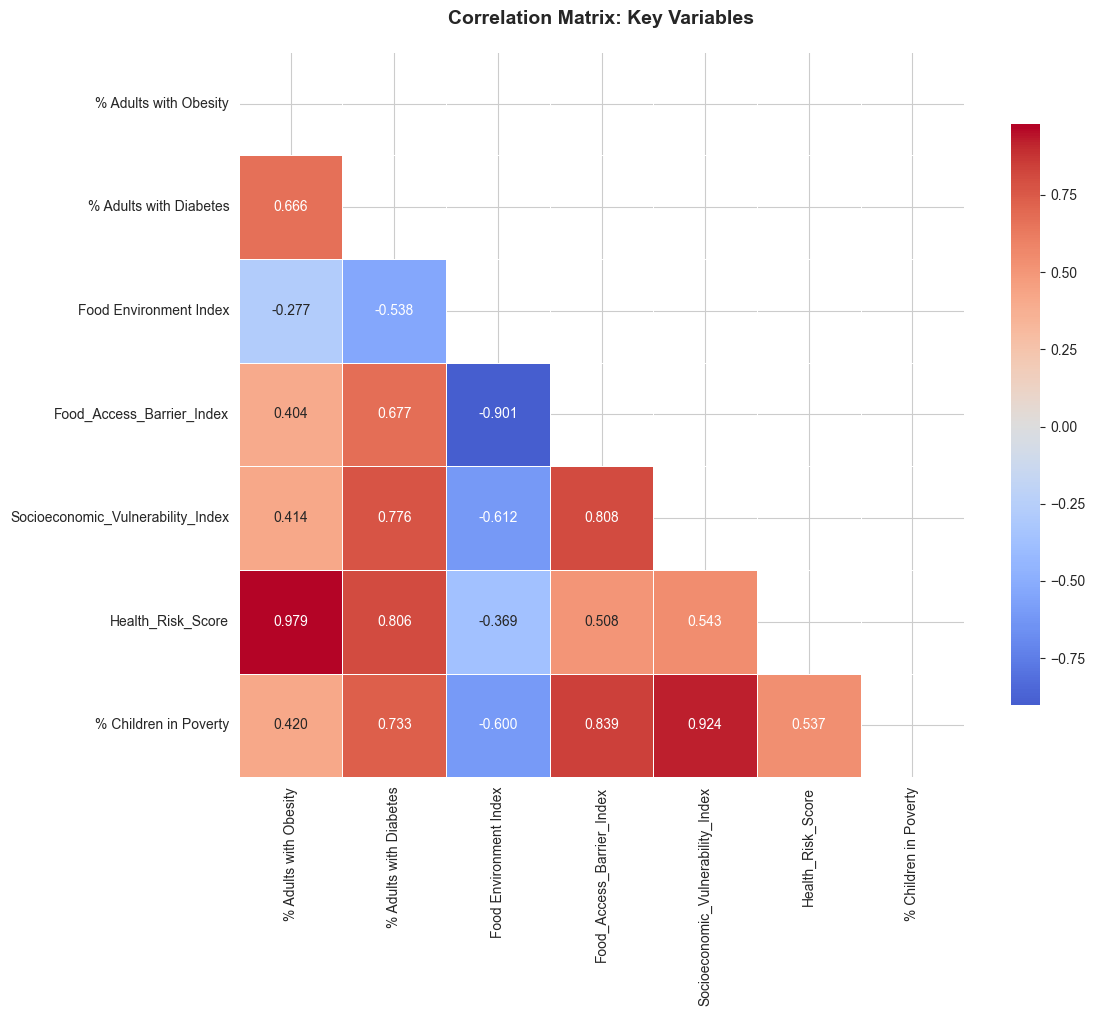

Correlation heatmap displayed


In [78]:
# Create a quick correlation heatmap for key variables
key_vars = [
    '% Adults with Obesity',
    '% Adults with Diabetes',
    'Food Environment Index',
    'Food_Access_Barrier_Index',
    'Socioeconomic_Vulnerability_Index',
    'Health_Risk_Score',
    '% Children in Poverty'
]

available_vars = [col for col in key_vars if col in df.columns]

plt.figure(figsize=(12, 10))
corr_matrix = df[available_vars].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title('Correlation Matrix: Key Variables', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("Correlation heatmap displayed")

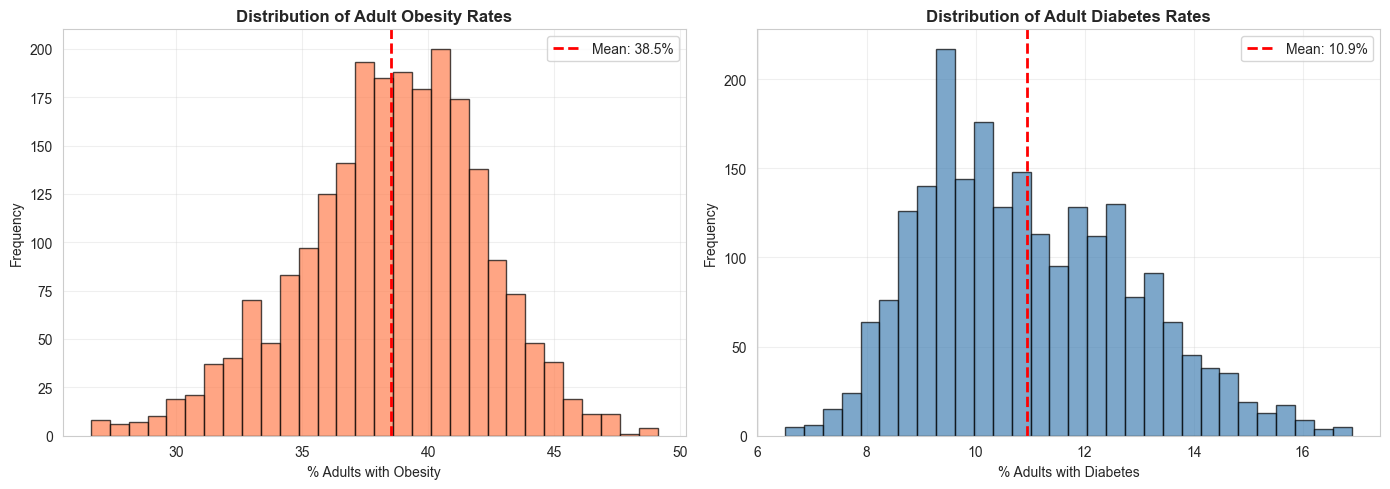

Distribution plots displayed


In [79]:
# Distribution plots for key health outcomes
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Obesity distribution
axes[0].hist(df['% Adults with Obesity'].dropna(), bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[0].axvline(df['% Adults with Obesity'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['% Adults with Obesity'].mean():.1f}%")
axes[0].set_xlabel('% Adults with Obesity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Adult Obesity Rates', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Diabetes distribution
axes[1].hist(df['% Adults with Diabetes'].dropna(), bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(df['% Adults with Diabetes'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: {df['% Adults with Diabetes'].mean():.1f}%")
axes[1].set_xlabel('% Adults with Diabetes')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Adult Diabetes Rates', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Distribution plots displayed")

## 13. Export Data Dictionary

In [ ]:
# Create data dictionary
data_dict = pd.DataFrame({
    'Column_Name': df.columns,
    'Data_Type': df.dtypes.astype(str),
    'Non_Null_Count': df.count(),
    'Null_Count': df.isnull().sum(),
    'Null_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})

# Add descriptive statistics for numeric columns
numeric_stats = df.describe().T[['mean', 'std', 'min', 'max']].round(3)
data_dict = data_dict.merge(numeric_stats, left_on='Column_Name', right_index=True, how='left')

# Save data dictionary
dict_file = '/Users/savithavijayarangan/Desktop/ML group project/data/output/data_dictionary.csv'
data_dict.to_csv(dict_file, index=False)

print(f"Data dictionary saved to: {dict_file}")
print("\nPreview:")
data_dict.head(10)

In [86]:
print("\n" + "="*70)
print("DATA CLEANING & PREPROCESSING COMPLETE!")
print("="*70)
print(f"\nFinal dataset: {df.shape[0]:,} records × {df.shape[1]} features")



DATA CLEANING & PREPROCESSING COMPLETE!

Final dataset: 2,275 records × 45 features


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/Users/savithavijayarangan/Desktop/ML group project/data/output/cleaned_health_data.csv')
print(f"Original shape: {df.shape}")

print("\n" + "="*70)
print("METHOD 1: Food Environment Index Threshold")
print("="*70)

# Create binary indicator based on threshold
FOOD_INDEX_THRESHOLD = 7.0  # Areas below this are considered food deserts

df['Food_Desert_Index'] = (df['Food Environment Index'] < FOOD_INDEX_THRESHOLD).astype(int)

# Handle missing values
df['Food_Desert_Index'] = df['Food_Desert_Index'].fillna(-1)  # -1 for missing data

# Summary
print(f"\nThreshold used: Food Environment Index < {FOOD_INDEX_THRESHOLD}")
print(f"\nFood Desert Distribution:")
print(df['Food_Desert_Index'].value_counts().sort_index())
print(f"\nProportions:")
print(df['Food_Desert_Index'].value_counts(normalize=True).sort_index())

In [ ]:
# Save the updated dataframe to the same file or a new one
output_path = '/Users/savithavijayarangan/Desktop/ML group project/data/output/cleaned_health_data.csv'

df.to_csv(output_path, index=False)
print(f"\n 'Food_Desert_Index' column successfully added and saved to: {output_path}")